In [ ]:
import numpy as np
import pandas as pd
import os
import pickle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import r2_score, mean_absolute_error
from scipy.stats import pearsonr, spearmanr, linregress
from lifelines.utils import concordance_index
from matplotlib.colors import LinearSegmentedColormap, Normalize
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import linkage
from matplotlib import rcParams
# Assuming dynamicTreeCut is installed and available
from dynamicTreeCut import cutreeHybrid


## EGFR-Erlotinib Pair

#### Data Processing for Model

In [179]:
drug_target_data = pd.read_csv("../Data/Drug_target_data.csv", index_col=0)

In [180]:
drug_hcg = pd.read_csv("../Data/Drug_HCG_data.csv", index_col=0)

In [212]:
drug_cell_line = pd.read_csv("../Data/Drug_cell_line_data.csv", index_col=0)

In [182]:
Exp = pd.read_csv("../Data/Expression_string_ppi_new.csv", index_col=0)

In [ ]:
Dep = pd.read_csv("../Data/Dep.csv", index_col=0)

In [161]:
# Rename 'OSA1777' to 'SYO1' in the index
Dep.rename(index={'OSA1777': 'SYO1'}, inplace=True)

In [ ]:
IC50 = pd.read_csv("../Data/Creammist_common_ic50.csv", index_col=0)

In [163]:
IC50.columns = IC50.columns.str.replace('-', '')

In [164]:
# Drop duplicated columns (keep the first occurrence)
IC50 = IC50.loc[:, ~IC50.columns.duplicated(keep='first')]

In [165]:
# --- 2. Configuration ---
DRUG_NAME = 'ERLOTINIB'

# Get the target gene(s)
erlotinib_targets = drug_target_data.loc[DRUG_NAME, 'Target'].split(',')
print(f"Targets for {DRUG_NAME}: {erlotinib_targets}")
# For this problem, we assume the first target is the primary one for dependency
primary_target = erlotinib_targets[0]

# Get the list of highly correlated genes (HCGs)
erlotinib_genes_str = drug_hcg.loc[DRUG_NAME, 'HCG_list']
erlotinib_gene_list = erlotinib_genes_str.split(',')
print(f"Found {len(erlotinib_gene_list)} HCG genes for {DRUG_NAME}.")

# Get the list of cell lines
erlotinib_cell_lines_str = drug_cell_line.loc[DRUG_NAME, 'Cell lines']
erlotinib_cell_line_list = erlotinib_cell_lines_str.split(',')
print(f"Found {len(erlotinib_cell_line_list)} cell lines for {DRUG_NAME}.")
print("-" * 30)

# --- 4. Create the Final E, D, and I Matrices ---

# Find the intersection of desired genes/cells with what's available in the data
final_genes = sorted(list(set(erlotinib_gene_list) & set(Exp.columns)))
final_cell_lines = sorted(list(set(erlotinib_cell_line_list) & set(Exp.index) & set(Dep.index)))

print(f"Final common cell lines to use: {len(final_cell_lines)}")
print(f"Final common genes to use: {len(final_genes)}")
print("-" * 30)

# --- Create Expression Matrix (E) ---
E = Exp.loc[final_cell_lines, final_genes]

# --- Create Dependency Matrix (D) ---
# Ensure the primary target is actually a column in the dependency data
if primary_target not in Dep.columns:
    raise ValueError(f"Primary target '{primary_target}' not found in dependency data columns!")
D = pd.DataFrame(Dep.loc[final_cell_lines, primary_target])
D.columns = [f"{primary_target}"]


# --- Create IC50 Matrix (I) ---
erlotinib_ic50_series = IC50.loc[DRUG_NAME]
I = pd.DataFrame(erlotinib_ic50_series[final_cell_lines])
I.columns = [f"{DRUG_NAME}"]


Targets for ERLOTINIB: ['EGFR']
Found 200 HCG genes for ERLOTINIB.
Found 658 cell lines for ERLOTINIB.
------------------------------
Final common cell lines to use: 658
Final common genes to use: 200
------------------------------


In [167]:
E.shape, D.shape, I.shape

((658, 200), (658, 1), (658, 1))

In [168]:
# === 2. Prepare Data (with Reproducibility Fix) ===

# Find common cell lines across all three dataframes
common_cell_lines_set = set(E.index) & set(D.index) & set(I.index)
common_cell_lines = sorted(list(common_cell_lines_set))

# Re-index the DataFrames using the sorted list of common cell lines
E_common = E.loc[common_cell_lines]
D_common = D.loc[common_cell_lines]
I_common = I.loc[common_cell_lines]

# Extract raw values
E_mat = E_common.values
D_vec_raw = D_common.values.ravel()
I_vec_raw = I_common.values.ravel()
len(common_cell_lines)

658

In [169]:
# === 4. Split Data Deterministically ===
train_idx, test_idx = train_test_split(
    np.arange(len(E_mat)), test_size=0.2, random_state=42
)

print(f"Number of training samples: {len(train_idx)}")
print(f"Number of testing samples: {len(test_idx)}")


E_train_raw, E_test_raw = E_mat[train_idx], E_mat[test_idx]
D_train_raw, D_test_raw = D_vec_raw[train_idx], D_vec_raw[test_idx]
I_train_raw, I_test_raw = I_vec_raw[train_idx], I_vec_raw[test_idx]

# === ✅ Fit on Train, Transform on Test ===
scaler_E = StandardScaler()
E_train = scaler_E.fit_transform(E_train_raw)
E_test = scaler_E.transform(E_test_raw)

# Mean-center D and I
D_train = D_train_raw - D_train_raw.mean()
D_test = D_test_raw - D_train_raw.mean()  # use train mean
I_train = I_train_raw - I_train_raw.mean()
I_test = I_test_raw - I_train_raw.mean()  # use train mean

# Track original cell line names and raw values
cell_line_names_train = E_common.index[train_idx]
cell_line_names_test = E_common.index[test_idx]
raw_dep_train, raw_dep_test = D_train_raw, D_test_raw
raw_ic50_train, raw_ic50_test = I_train_raw, I_test_raw

Number of training samples: 526
Number of testing samples: 132


#### Model Building 

In [ ]:
# === 3. Set Parameters for the Specific Run ===
latent_dim = 40  # r = 40
bootstrap_iter = 0 # b = 0
seed = 198716

save_dir = "Erlotinib_Latent_model_40_b0_new"
os.makedirs(save_dir, exist_ok=True)


# === 5. Run the Model Training ===
print(f"Running training for latent_dim={latent_dim}, bootstrap={bootstrap_iter} (seed={seed})...")

# Set the seed for NumPy's random operations to ensure W is initialized the same way
np.random.seed(seed)

p = E_train.shape[1] # Number of features
W = np.random.randn(p, latent_dim)

# Hyperparameters
lr = 1e-3
lmbda = 0.01
epochs = 1500

from sklearn.metrics import mean_squared_error


# Training loop with loss tracking
for epoch in range(epochs):
    Z = E_train @ W
    h_I = np.linalg.pinv(Z.T @ Z) @ Z.T @ I_train
    h_D = np.linalg.pinv(Z.T @ Z) @ Z.T @ D_train

    pred_I = Z @ h_I
    pred_D = Z @ h_D

    grad_W = (
        2 * E_train.T @ ((pred_I - I_train)[:, None] * h_I[None, :]) +
        2 * E_train.T @ ((pred_D - D_train)[:, None] * h_D[None, :]) +
        lmbda * np.sign(W)
    )
    W -= lr * grad_W

    # Print loss every 50 epochs
    if (epoch + 1) % 50 == 0 or epoch == 0:
        # --- Training Loss ---
        train_loss_I = mean_squared_error(I_train, pred_I)
        train_loss_D = mean_squared_error(D_train, pred_D)

        # --- Testing Loss ---
        Z_test = E_test @ W
        pred_I_test = Z_test @ h_I
        pred_D_test = Z_test @ h_D
        test_loss_I = mean_squared_error(I_test, pred_I_test)
        test_loss_D = mean_squared_error(D_test, pred_D_test)

        print(f"Epoch {epoch + 1:03d}: "
              f"Train Loss [I: {train_loss_I:.4f}, D: {train_loss_D:.4f}] | "
              f"Test Loss [I: {test_loss_I:.4f}, D: {test_loss_D:.4f}]")
              



Running training for latent_dim=40, bootstrap=0 (seed=42)...
Epoch 001: Train Loss [I: 4.4046, D: 0.0600] | Test Loss [I: 4.9767, D: 0.0686]
Epoch 050: Train Loss [I: 3.7217, D: 0.0594] | Test Loss [I: 5.1077, D: 0.0682]
Epoch 100: Train Loss [I: 3.3172, D: 0.0593] | Test Loss [I: 5.5942, D: 0.0686]
Epoch 150: Train Loss [I: 3.0817, D: 0.0591] | Test Loss [I: 6.0123, D: 0.0689]
Epoch 200: Train Loss [I: 2.9616, D: 0.0588] | Test Loss [I: 6.2219, D: 0.0690]
Epoch 250: Train Loss [I: 2.9020, D: 0.0586] | Test Loss [I: 6.3319, D: 0.0691]
Epoch 300: Train Loss [I: 2.8715, D: 0.0583] | Test Loss [I: 6.4007, D: 0.0691]
Epoch 350: Train Loss [I: 2.8556, D: 0.0581] | Test Loss [I: 6.4449, D: 0.0692]
Epoch 400: Train Loss [I: 2.8472, D: 0.0579] | Test Loss [I: 6.4717, D: 0.0692]
Epoch 450: Train Loss [I: 2.8427, D: 0.0577] | Test Loss [I: 6.4865, D: 0.0692]
Epoch 500: Train Loss [I: 2.8402, D: 0.0574] | Test Loss [I: 6.4939, D: 0.0692]


In [171]:
# === 6. Evaluate and Prepare for Saving ===
# Test evaluation
Z_test = E_test @ W
pred_I_test = Z_test @ h_I
pred_D_test = Z_test @ h_D
corr_I_test = pearsonr(pred_I_test, I_test)[0]
corr_D_test = pearsonr(pred_D_test, D_test)[0]

# Train evaluation
Z_train = E_train @ W
pred_I_train = Z_train @ h_I
pred_D_train = Z_train @ h_D
corr_I_train = pearsonr(pred_I_train, I_train)[0]
corr_D_train = pearsonr(pred_D_train, D_train)[0]

# === 6.5 Compute Benefit Score and Influence ===

# Compute Benefit Score = Dependency - IC50
benefit_train = pred_D_train - pred_I_train
benefit_test = pred_D_test - pred_I_test

# Gene influence calculation (L2 scaled)
def calculate_scaled_gene_influence(W, h_D, h_I, gene_names):
    h_D_norm = h_D / np.linalg.norm(h_D)
    h_I_norm = h_I / np.linalg.norm(h_I)

    ic50_effect = -W @ h_I_norm
    dependency_effect = W @ h_D_norm
    total_influence = dependency_effect + ic50_effect

    influence_df = pd.DataFrame({
        "Gene": gene_names,
        "IC50Effect": ic50_effect.ravel(),
        "DependencyEffect": dependency_effect.ravel(),
        "TotalInfluence": total_influence.ravel()
    }, index=gene_names)

    return influence_df

# Get gene names from original E matrix columns
gene_names = E_common.columns.tolist()

# Compute influence
influence_df = calculate_scaled_gene_influence(W, h_D, h_I, gene_names)

influence_df.head()

,Gene,IC50Effect,DependencyEffect,TotalInfluence
ADAMTS12,ADAMTS12,-0.182319,-0.248124,-0.430442
ADGRF4,ADGRF4,0.392302,-0.135319,0.256983
ALS2CL,ALS2CL,-0.726338,-0.168815,-0.895153
AMDHD2,AMDHD2,0.578423,0.953771,1.532194
ANXA3,ANXA3,0.222061,0.670654,0.892715


#### Saving the data

In [172]:
# === 7. Save All Necessary Objects for Reproducibility ===
# This dictionary contains everything needed to reproduce your analysis later
save_dict = {
    # Model parameters
    "W": W,
    "h_D": h_D,
    "h_I": h_I,
    
    # Processed data used for training/testing
    "E_train": E_train, "E_test": E_test,
    "D_train": D_train, "D_test": D_test,
    "I_train": I_train, "I_test": I_test,
    
    # Identifiers and original values needed for plotting and analysis
    "cell_line_names_train": cell_line_names_train,
    "cell_line_names_test": cell_line_names_test,
    "raw_dep_train": raw_dep_train,
    "raw_dep_test": raw_dep_test,
    "raw_ic50_train": raw_ic50_train,
    "raw_ic50_test": raw_ic50_test,
    
    # Benefit and influence results
    "benefit_train": benefit_train,
    "benefit_test": benefit_test,
    "influence_df": influence_df,

    
    # Performance metrics
    "train_corr_I": corr_I_train,
    "train_corr_D": corr_D_train,
    "test_corr_I": corr_I_test,
    "test_corr_D": corr_D_test,
    
    # Parameters used for this run
    "latent_dim": latent_dim,
    "bootstrap_iter": bootstrap_iter,
    "seed": seed,
    "scaler_E": scaler_E,
    "gene_names": gene_names

}

# Define the save path and save the file
save_path = os.path.join(save_dir, f"model_r{latent_dim}_b{bootstrap_iter}.pkl")
with open(save_path, "wb") as f:
    pickle.dump(save_dict, f)

print(f"Successfully saved all model components and data to: {save_path}")

Successfully saved all model components and data to: Latent_model_40_b0/model_r40_b0.pkl


#### Scatterplot of True vs Predicted Values 

In [185]:
# === Plot aesthetics
sns.set(style="white", context="talk", font_scale=1.1)

def annotate_and_regress(ax, x, y, title, xlabel, ylabel):
    x = x.flatten()
    y = y.flatten()

    # === Compute metrics
    pearson_corr, _ = pearsonr(x, y)
    spearman_corr, _ = spearmanr(x, y)
    r2 = r2_score(x, y)
    mae = mean_absolute_error(x, y)
    ci = concordance_index(x, y)

    # === Plot regression with confidence interval
    sns.regplot(
        x=x,
        y=y,
        ax=ax,
        color='darkslategrey',  # Line + CI color
        scatter_kws={'s': 40, 'alpha': 0.8, 'color': 'seagreen','rasterized': False, 'edgecolors': 'black', 'linewidths': 0.1},
        line_kws={'color': 'darkslategrey', 'label': 'OLS Fit'},
        ci=100
    )

    # === Axis labels and title
    ax.set_title(title, fontsize=16)
    ax.set_xlabel(xlabel, fontsize=14)
    ax.set_ylabel(ylabel, fontsize=14)

    # === Metrics box
    metrics_text = (
        f"Pearson r   = {pearson_corr:.2f}\n"
        f"Spearman ρ  = {spearman_corr:.2f}\n"
        f"R² Score    = {r2:.2f}\n"
        f"MAE         = {mae:.2f}\n"
        f"C-Index     = {ci:.2f}"
    )
    ax.text(0.05, 0.95, metrics_text,
            transform=ax.transAxes,
            fontsize=11,
            va='top', ha='left',
            bbox=dict(boxstyle='round', facecolor='white', edgecolor='grey', alpha=0.9))

    # === Clean up style
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    # === ✅ Keep ticks only on left and bottom
    ax.tick_params(axis='both', which='both', bottom=True, top=False, left=True, right=False)
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.legend(loc='lower right', frameon=False)

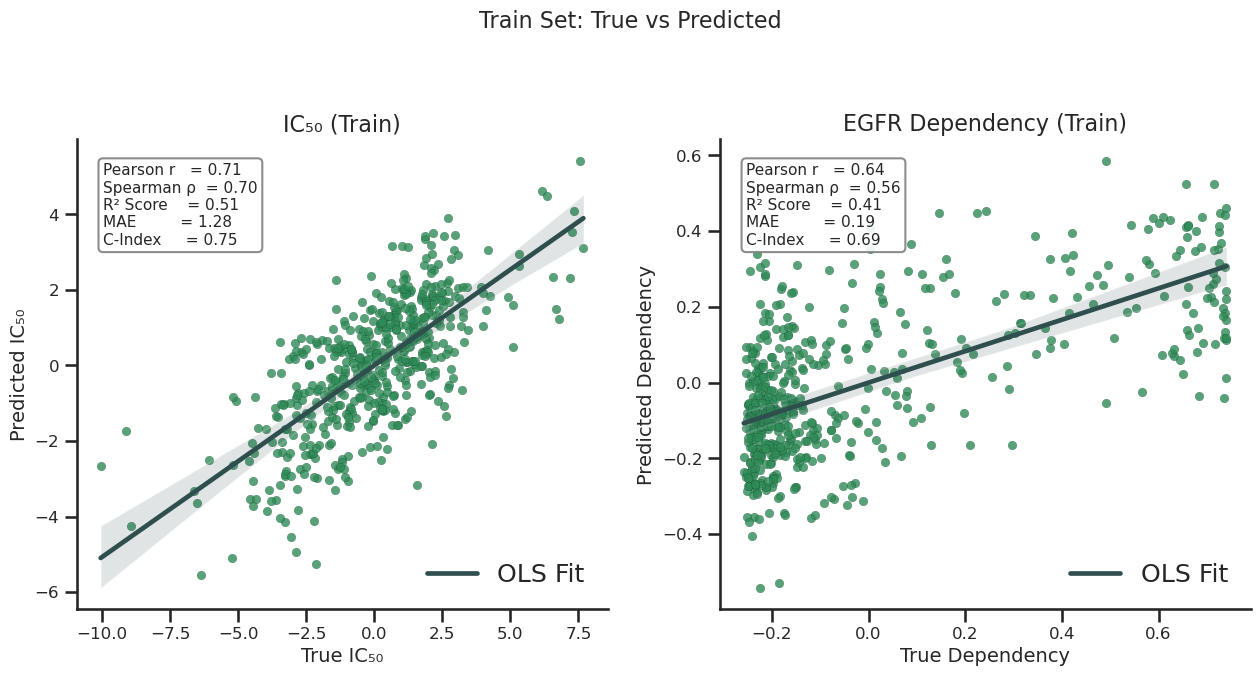

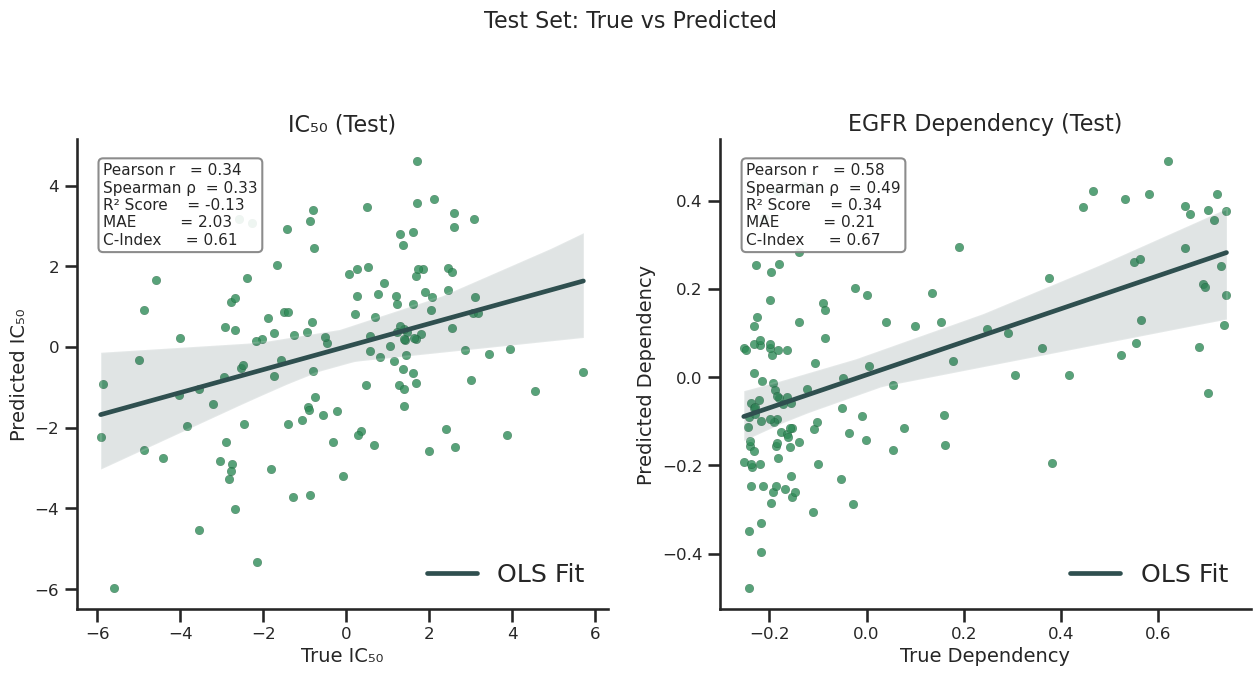

In [186]:
# === Create helper function to handle both plots in a single figure
def plot_two_subplots(x1, y1, x2, y2, title1, title2, xlabel1, ylabel1, xlabel2, ylabel2, main_title):
    fig, axes = plt.subplots(1, 2, figsize=(13, 7))
    
    # Subplot 1
    annotate_and_regress(
        ax=axes[0],
        x=x1,
        y=y1,
        title=title1,
        xlabel=xlabel1,
        ylabel=ylabel1
    )
    
    # Subplot 2
    annotate_and_regress(
        ax=axes[1],
        x=x2,
        y=y2,
        title=title2,
        xlabel=xlabel2,
        ylabel=ylabel2
    )

    fig.suptitle(main_title, fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


# === 🚂 Train Set: True vs Pred IC₅₀ and Dependency
plot_two_subplots(
    x1=I_train,
    y1=pred_I_train,
    x2=D_train,
    y2=pred_D_train,
    title1="IC₅₀ (Train)",
    title2="EGFR Dependency (Train)",
    xlabel1="True IC₅₀",
    ylabel1="Predicted IC₅₀",
    xlabel2="True Dependency",
    ylabel2="Predicted Dependency",
    main_title="Train Set: True vs Predicted"
)

# === 🧪 Test Set: True vs Pred IC₅₀ and Dependency
plot_two_subplots(
    x1=I_test,
    y1=pred_I_test,
    x2=D_test,
    y2=pred_D_test,
    title1="IC₅₀ (Test)",
    title2="EGFR Dependency (Test)",
    xlabel1="True IC₅₀",
    ylabel1="Predicted IC₅₀",
    xlabel2="True Dependency",
    ylabel2="Predicted Dependency",
    main_title="Test Set: True vs Predicted"
)


#### Heatmap_cell_line

In [190]:
# ---!!!--- IMPORTANT: SIMULATION OF PREDICTED VALUES ---!!!---
pred_dep_train = Z_train @ h_D
pred_ic50_train = Z_train @ h_I
pred_dep_test = Z_test @ h_D
pred_ic50_test = Z_test @ h_I
# --- END OF SIMULATION BLOCK ---

# --- Create separate DataFrames for train and test ---
# Training DataFrame
Z_train_df = pd.DataFrame(Z_train, index=cell_line_names_train, columns=[i + 1 for i in range(Z_train.shape[1])])
Z_train_df["actual_dep_EGFR"] = raw_dep_train
Z_train_df["actual_IC50"] = raw_ic50_train
Z_train_df["pred_dep_EGFR"] = pred_dep_train
Z_train_df["pred_IC50"] = pred_ic50_train
Z_train_df["Set"] = "Train"

# Testing DataFrame
Z_test_df = pd.DataFrame(Z_test, index=cell_line_names_test, columns=[i + 1 for i in range(Z_test.shape[1])])
Z_test_df["actual_dep_EGFR"] = raw_dep_test
Z_test_df["actual_IC50"] = raw_ic50_test
Z_test_df["pred_dep_EGFR"] = pred_dep_test
Z_test_df["pred_IC50"] = pred_ic50_test
Z_test_df["Set"] = "Test"

# --- Combine into a single DataFrame ---
Z_combined_df = pd.concat([Z_train_df, Z_test_df])
Z_combined_df["Benefit_Score"] = Z_combined_df["pred_dep_EGFR"] - Z_combined_df["pred_IC50"]
Z_combined_df.index.name = "Cell_line"

# The final dataframe for plotting (only latent factors)
Z_plot_df = Z_combined_df.iloc[:, :Z_train.shape[1]]

print("Z_combined_df DataFrame successfully created:")
Z_combined_df.head()
print(f"Total cell lines to plot: {len(Z_combined_df)}")


Z_combined_df DataFrame successfully created:
Total cell lines to plot: 658


Performing hierarchical clustering on the combined dataset...
..cutHeight not given, setting it to 1509.692160145153  ===>  99% of the (truncated) height range in dendro.
..done.
Dynamic Tree Cut found 28 clusters.
Generating the final heatmap...


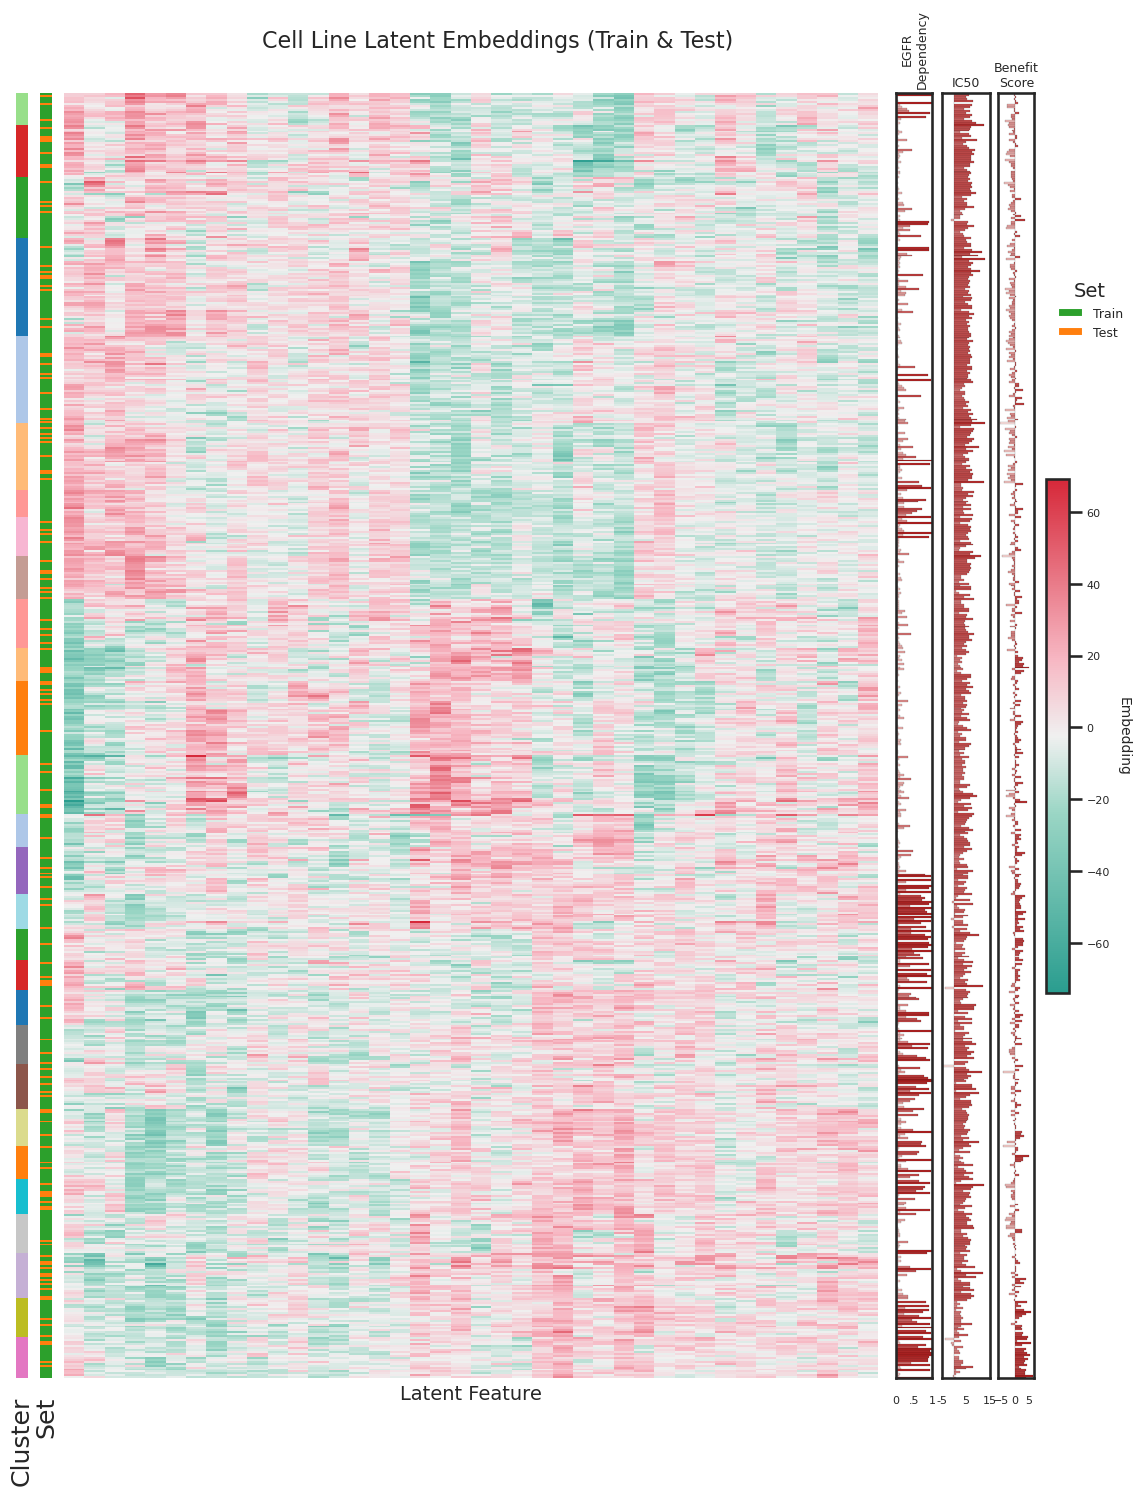

In [200]:
# === 3. Hierarchical Clustering and Annotation Color Mapping (on Combined Data) ===
print("Performing hierarchical clustering on the combined dataset...")

# --- Step 3a: Compute linkage matrices for the combined data ---
row_dist = pdist(Z_plot_df.values, metric='euclidean')
row_link = linkage(row_dist, method='ward')
col_link = linkage(pdist(Z_plot_df.T.values), method='ward')

# --- Step 3b: Run Dynamic Tree Cut to find clusters ---
cluster_result = cutreeHybrid(row_link, row_dist,deepSplit=4, minClusterSize=14) # Set a min size
cluster_labels = pd.Series(cluster_result["labels"], index=Z_plot_df.index, name="Cluster")
num_clusters = len(np.unique(cluster_labels[cluster_labels != 0]))
print(f"Dynamic Tree Cut found {num_clusters} clusters.")

# --- Step 3c: Create annotation colors ---
# This will be a DataFrame, as clustermap can plot multiple annotation bars
row_colors_df = pd.DataFrame(index=Z_plot_df.index)

# Annotation 1: Dynamic Tree Cut Clusters
unique_clusters = sorted(np.unique(cluster_labels))
palette = sns.color_palette("tab20", len(unique_clusters))
cluster_lut = dict(zip(unique_clusters, palette))
cluster_lut[0] = 'lightgrey'  # Unclustered points
row_colors_df["Cluster"] = cluster_labels.map(cluster_lut)

# Annotation 2: Train vs. Test Set
set_lut = {"Train": "#2ca02c", "Test": "#ff7f0e"} # Green and Orange
row_colors_df["Set"] = Z_combined_df["Set"].map(set_lut)

row_colors_df[" "] = "#ffffff"  # White bar to add space between cluster and set
# Reorder to force the stacking order: Cluster (top), Spacer, then Set
row_colors_df = row_colors_df[["Cluster", " ", "Set"]]


# === 4. Define Colormaps ===
deep_green = '#2a9d8f'; soft_green = '#9bd6c5'; neutral = '#f0f0f0'; soft_pink = '#f7b7c3'; deep_pink = '#d62839'
green_pink_cmap = LinearSegmentedColormap.from_list('green_pink_cmap', [(0.0, deep_green), (0.35, soft_green), (0.5, neutral), (0.65, soft_pink), (1.0, deep_pink)], N=256)
muted_reds = LinearSegmentedColormap.from_list("muted_reds", ["mistyrose", "indianred", "firebrick"])
benefit_cmap = sns.diverging_palette(240, 10, as_cmap=True) # Blue to Red for benefit score

# === 5. Generate the Final Clustered Heatmap ===
print("Generating the final heatmap...")
cg = sns.clustermap(
    Z_plot_df,
    row_linkage=row_link,
    col_linkage=col_link,
    row_colors=row_colors_df,  # Pass the DataFrame with both annotations
    cmap=green_pink_cmap,
    figsize=(12, 15),
    cbar_pos=None, # We will create all colorbars manually
    dendrogram_ratio=(0.04, 0.03),
    linewidths=0
)

# Rasterize the heatmap blocks (all quadmesh artists in heatmap)
for artist in cg.ax_heatmap.collections:
    artist.set_rasterized(True)

# === 6. Fine-tune Layout and Add Side Plots ===
fig = cg.fig
heatmap_ax = cg.ax_heatmap
# Remove latent dimension numbers from the x-axis
heatmap_ax.set_xticklabels([])
heatmap_ax.set_xticks([])  # Optional: remove the ticks themselves
heatmap_pos = heatmap_ax.get_position()


# --- Adjust annotation and dendrogram positions ---
cg.ax_row_colors.set_position([heatmap_pos.x0 - 0.04, heatmap_pos.y0, 0.03, heatmap_pos.height])
if cg.ax_col_colors is not None:
    cg.ax_col_colors.set_visible(False)



#cg.ax_col_colors.set_visible(False) # Hide column colors if they exist
dendro_ax = cg.ax_row_dendrogram
dendro_ax.set_position([0.02, heatmap_pos.y0, 0.05, heatmap_pos.height])

cg.ax_row_dendrogram.set_visible(False)
cg.ax_col_dendrogram.set_visible(False)


# --- Configure heatmap axes and labels ---
row_order = cg.dendrogram_row.reordered_ind
ordered_labels = Z_plot_df.index[row_order]
tick_labels = [label if i % 10 == 0 else "" for i, label in enumerate(ordered_labels)] # Adjust frequency
heatmap_ax.set_yticks(np.arange(len(ordered_labels)) + 0.5)
#heatmap_ax.set_yticklabels(tick_labels, fontsize=6.5, rotation=0)
heatmap_ax.set_yticklabels([])
heatmap_ax.set_yticks([])

heatmap_ax.tick_params(axis='y', labelright=False, labelleft=True, length=0, pad=1)

# --- Add Bar Plot 1: EGFR Dependency ---
egfr_ax = fig.add_axes([heatmap_pos.x1 + 0.015, heatmap_pos.y0, 0.03, heatmap_pos.height])
egfr_vals = Z_combined_df.loc[ordered_labels, "actual_dep_EGFR"]
egfr_colors = muted_reds(Normalize(vmin=0, vmax=1)(egfr_vals))
egfr_ax.barh(np.arange(len(egfr_vals)), egfr_vals, height=1.0, color=egfr_colors, edgecolor='black', linewidth=0.1)
egfr_ax.set_xlim(0, 1); egfr_ax.set_ylim(0, len(ordered_labels))
egfr_ax.set_xticks([0, 0.5, 1]); egfr_ax.set_xticklabels(["0", ".5", "1"], fontsize=8)
egfr_ax.set_yticks([]); egfr_ax.set_title("EGFR\nDependency", fontsize=9, rotation=90)
for bar in egfr_ax.patches:
    bar.set_rasterized(True)

# --- Add Bar Plot 2: IC50 ---
ic50_ax = fig.add_axes([heatmap_pos.x1 + 0.053, heatmap_pos.y0, 0.04, heatmap_pos.height])
ic50_vals = Z_combined_df.loc[ordered_labels, "actual_IC50"]
ic50_colors = muted_reds(Normalize(vmin=-5, vmax=15)(ic50_vals))
ic50_ax.barh(np.arange(len(ic50_vals)), ic50_vals, height=1.0, color=ic50_colors, edgecolor='black', linewidth=0.1)
ic50_ax.set_xlim(-5, 15); ic50_ax.set_ylim(0, len(ordered_labels))
ic50_ax.set_xticks([-5, 5, 15]); ic50_ax.set_xticklabels(["-5", "5", "15"], fontsize=8)
ic50_ax.set_yticks([]); ic50_ax.set_title("IC50", fontsize=9, loc='center', pad=5)
for bar in ic50_ax.patches:
    bar.set_rasterized(True)


# --- Add Bar Plot 3: Benefit Score ---
benefit_ax = fig.add_axes([heatmap_pos.x1 + 0.1, heatmap_pos.y0, 0.03, heatmap_pos.height])
benefit_vals = Z_combined_df.loc[ordered_labels, "Benefit_Score"]
benefit_colors = muted_reds(Normalize(vmin=benefit_vals.min(), vmax=benefit_vals.max())(benefit_vals))
#benefit_norm = Normalize(vmin=benefit_vals.min(), vmax=benefit_vals.max())
#benefit_ax.barh(np.arange(len(benefit_vals)), benefit_vals, height=1.0, color=benefit_cmap(benefit_norm(benefit_vals)))
benefit_ax.barh(np.arange(len(benefit_vals)), benefit_vals, height=1.0, color=benefit_colors, edgecolor='black', linewidth=0.1)
benefit_ax.set_ylim(0, len(ordered_labels)); benefit_ax.set_yticks([])
benefit_ax.tick_params(axis='x', labelsize=8)
benefit_ax.set_title("Benefit\nScore", fontsize=9, loc='center', pad=5)
for bar in benefit_ax.patches:
    bar.set_rasterized(True)


# --- Add Manual Colorbar for Heatmap ---
#cbar_ax = fig.add_axes([heatmap_pos.x1 + 0.15, heatmap_pos.y0, 0.015, heatmap_pos.height * 0.4])
cbar_ax = fig.add_axes([
    heatmap_pos.x1 + 0.14,                                 # right of bar plots
    heatmap_pos.y0 + heatmap_pos.height * 0.3,             # vertically centered
    0.019,
    heatmap_pos.height * 0.4
])
vmin, vmax = Z_plot_df.values.min(), Z_plot_df.values.max()
norm = Normalize(vmin=vmin, vmax=vmax)
sm = plt.cm.ScalarMappable(cmap=green_pink_cmap, norm=norm)
cbar = fig.colorbar(sm, cax=cbar_ax)
cbar.ax.tick_params(labelsize=8)
cbar.set_label('Embedding', fontsize=10, rotation=270, labelpad=15)


# --- Add Manual Legend for Cluster and Set Annotations ---
from matplotlib.patches import Patch
legend_ax = fig.add_axes([heatmap_pos.x1 + 0.14, heatmap_pos.y0 + heatmap_pos.height*0.80, 0.015, heatmap_pos.height*0.25])
handles = [Patch(facecolor=color, label=label) for label, color in set_lut.items()]
legend_ax.legend(handles=handles, title='Set', frameon=False, loc='lower left', fontsize=9, title_fontsize = 14)
legend_ax.axis('off')
# --- Add Manual Legend for Cluster and Set Annotations --


# --- Final Titles and Layout Adjustments ---
heatmap_ax.set_xlabel("Latent Feature", fontsize=14); heatmap_ax.set_ylabel("")
num_cell_lines = len(Z_combined_df)
fig.suptitle(f"Cell Line Latent Embeddings (Train & Test)", y=0.99, fontsize=16)


plt.show()

## NAMPT - Daporinad 

In [214]:
# --- 2. Configuration ---
DRUG_NAME = 'DAPORINAD'

# Get the target gene(s)
daporinad_targets = drug_target_data.loc[DRUG_NAME, 'Target'].split(',')
print(f"Targets for {DRUG_NAME}: {daporinad_targets}")
# For this problem, we assume the first target is the primary one for dependency
primary_target = daporinad_targets[0]

# Get the list of highly correlated genes (HCGs)
daporinad_genes_str = drug_hcg.loc[DRUG_NAME, 'HCG_list']
daporinad_gene_list = daporinad_genes_str.split(',')
print(f"Found {len(daporinad_gene_list)} HCG genes for {DRUG_NAME}.")

# Get the list of cell lines
daporinad_cell_lines_str = drug_cell_line.loc[DRUG_NAME, 'Cell lines']
daporinad_cell_line_list = daporinad_cell_lines_str.split(',')
print(f"Found {len(daporinad_cell_line_list)} cell lines for {DRUG_NAME}.")
print("-" * 30)

# --- 4. Create the Final E, D, and I Matrices ---

# Find the intersection of desired genes/cells with what's available in the data
final_genes = sorted(list(set(daporinad_gene_list) & set(Exp.columns)))
final_cell_lines = sorted(list(set(daporinad_cell_line_list) & set(Exp.index) & set(Dep.index)))

print(f"Final common cell lines to use: {len(final_cell_lines)}")
print(f"Final common genes to use: {len(final_genes)}")
print("-" * 30)

# --- Create Expression Matrix (E) ---
E = Exp.loc[final_cell_lines, final_genes]

# --- Create Dependency Matrix (D) ---
# Ensure the primary target is actually a column in the dependency data
if primary_target not in Dep.columns:
    raise ValueError(f"Primary target '{primary_target}' not found in dependency data columns!")
D = pd.DataFrame(Dep.loc[final_cell_lines, primary_target])
D.columns = [f"{primary_target}"]

# --- Create IC50 Matrix (I) ---
daporinad_ic50_series = IC50.loc[DRUG_NAME]
I = pd.DataFrame(daporinad_ic50_series[final_cell_lines])
I.columns = [f"{DRUG_NAME}"]


Targets for DAPORINAD: ['NAMPT']
Found 199 HCG genes for DAPORINAD.
Found 641 cell lines for DAPORINAD.
------------------------------
Final common cell lines to use: 622
Final common genes to use: 199
------------------------------


In [216]:
E.shape, D.shape, I.shape

((622, 199), (622, 1), (622, 1))

In [217]:
# === 2. Prepare Data (with Reproducibility Fix) ===

# Find common cell lines across all three dataframes
common_cell_lines_set = set(E.index) & set(D.index) & set(I.index)
common_cell_lines = sorted(list(common_cell_lines_set))

# Re-index the DataFrames using the sorted list of common cell lines
E_common = E.loc[common_cell_lines]
D_common = D.loc[common_cell_lines]
I_common = I.loc[common_cell_lines]

# Extract raw values
E_mat = E_common.values
D_vec_raw = D_common.values.ravel()
I_vec_raw = I_common.values.ravel()
len(common_cell_lines)

622

In [218]:
# === 4. Split Data Deterministically ===
train_idx, test_idx = train_test_split(
    np.arange(len(E_mat)), test_size=0.2, random_state=42
)

print(f"Number of training samples: {len(train_idx)}")
print(f"Number of testing samples: {len(test_idx)}")


E_train_raw, E_test_raw = E_mat[train_idx], E_mat[test_idx]
D_train_raw, D_test_raw = D_vec_raw[train_idx], D_vec_raw[test_idx]
I_train_raw, I_test_raw = I_vec_raw[train_idx], I_vec_raw[test_idx]

# === ✅ Fit on Train, Transform on Test ===
scaler_E = StandardScaler()
E_train = scaler_E.fit_transform(E_train_raw)
E_test = scaler_E.transform(E_test_raw)

# Mean-center D and I
D_train = D_train_raw - D_train_raw.mean()
D_test = D_test_raw - D_train_raw.mean()  # use train mean
I_train = I_train_raw - I_train_raw.mean()
I_test = I_test_raw - I_train_raw.mean()  # use train mean

# Track original cell line names and raw values
cell_line_names_train = E_common.index[train_idx]
cell_line_names_test = E_common.index[test_idx]
raw_dep_train, raw_dep_test = D_train_raw, D_test_raw
raw_ic50_train, raw_ic50_test = I_train_raw, I_test_raw

Number of training samples: 497
Number of testing samples: 125


In [220]:
# === 3. Set Parameters for the Specific Run ===
latent_dim = 40  # r = 40
bootstrap_iter = 0 # b = 0
seed = 42 + bootstrap_iter

save_dir = "Daporinad_Latent_model_40_b0"
os.makedirs(save_dir, exist_ok=True)


# === 5. Run the Model Training ===
print(f"Running training for latent_dim={latent_dim}, bootstrap={bootstrap_iter} (seed={seed})...")

# Set the seed for NumPy's random operations to ensure W is initialized the same way
np.random.seed(seed)

p = E_train.shape[1] # Number of features
W = np.random.randn(p, latent_dim)

# Hyperparameters
lr = 1e-3
lmbda = 0.01
epochs = 500

from sklearn.metrics import mean_squared_error


# Training loop with loss tracking
for epoch in range(epochs):
    Z = E_train @ W
    h_I = np.linalg.pinv(Z.T @ Z) @ Z.T @ I_train
    h_D = np.linalg.pinv(Z.T @ Z) @ Z.T @ D_train

    pred_I = Z @ h_I
    pred_D = Z @ h_D

    grad_W = (
        2 * E_train.T @ ((pred_I - I_train)[:, None] * h_I[None, :]) +
        2 * E_train.T @ ((pred_D - D_train)[:, None] * h_D[None, :]) +
        lmbda * np.sign(W)
    )
    W -= lr * grad_W

    # Print loss every 50 epochs
    if (epoch + 1) % 50 == 0 or epoch == 0:
        # --- Training Loss ---
        train_loss_I = mean_squared_error(I_train, pred_I)
        train_loss_D = mean_squared_error(D_train, pred_D)

        # --- Testing Loss ---
        Z_test = E_test @ W
        pred_I_test = Z_test @ h_I
        pred_D_test = Z_test @ h_D
        test_loss_I = mean_squared_error(I_test, pred_I_test)
        test_loss_D = mean_squared_error(D_test, pred_D_test)

        print(f"Epoch {epoch + 1:03d}: "
              f"Train Loss [I: {train_loss_I:.4f}, D: {train_loss_D:.4f}] | "
              f"Test Loss [I: {test_loss_I:.4f}, D: {test_loss_D:.4f}]")
              



Running training for latent_dim=40, bootstrap=0 (seed=42)...
Epoch 001: Train Loss [I: 10.3469, D: 0.0657] | Test Loss [I: 15.5869, D: 0.0977]
Epoch 050: Train Loss [I: 7.2470, D: 0.0653] | Test Loss [I: 17.4080, D: 0.0981]
Epoch 100: Train Loss [I: 6.5565, D: 0.0650] | Test Loss [I: 20.7194, D: 0.0979]
Epoch 150: Train Loss [I: 6.3946, D: 0.0647] | Test Loss [I: 22.1789, D: 0.0979]
Epoch 200: Train Loss [I: 6.3479, D: 0.0644] | Test Loss [I: 22.6969, D: 0.0980]
Epoch 250: Train Loss [I: 6.3323, D: 0.0640] | Test Loss [I: 22.9088, D: 0.0981]
Epoch 300: Train Loss [I: 6.3269, D: 0.0636] | Test Loss [I: 23.0128, D: 0.0982]
Epoch 350: Train Loss [I: 6.3251, D: 0.0633] | Test Loss [I: 23.0704, D: 0.0983]
Epoch 400: Train Loss [I: 6.3244, D: 0.0630] | Test Loss [I: 23.1047, D: 0.0984]
Epoch 450: Train Loss [I: 6.3241, D: 0.0627] | Test Loss [I: 23.1261, D: 0.0985]
Epoch 500: Train Loss [I: 6.3240, D: 0.0623] | Test Loss [I: 23.1397, D: 0.0987]


In [221]:
# === 6. Evaluate and Prepare for Saving ===
# Test evaluation
Z_test = E_test @ W
pred_I_test = Z_test @ h_I
pred_D_test = Z_test @ h_D
corr_I_test = pearsonr(pred_I_test, I_test)[0]
corr_D_test = pearsonr(pred_D_test, D_test)[0]

# Train evaluation
Z_train = E_train @ W
pred_I_train = Z_train @ h_I
pred_D_train = Z_train @ h_D
corr_I_train = pearsonr(pred_I_train, I_train)[0]
corr_D_train = pearsonr(pred_D_train, D_train)[0]

# === 6.5 Compute Benefit Score and Influence ===

# Compute Benefit Score = Dependency - IC50
benefit_train = pred_D_train - pred_I_train
benefit_test = pred_D_test - pred_I_test

# Gene influence calculation (L2 scaled)
def calculate_scaled_gene_influence(W, h_D, h_I, gene_names):
    h_D_norm = h_D / np.linalg.norm(h_D)
    h_I_norm = h_I / np.linalg.norm(h_I)

    ic50_effect = -W @ h_I_norm
    dependency_effect = W @ h_D_norm
    total_influence = dependency_effect + ic50_effect

    influence_df = pd.DataFrame({
        "Gene": gene_names,
        "IC50Effect": ic50_effect.ravel(),
        "DependencyEffect": dependency_effect.ravel(),
        "TotalInfluence": total_influence.ravel()
    }, index=gene_names)

    return influence_df

# Get gene names from original E matrix columns
gene_names = E_common.columns.tolist()

# Compute influence
influence_df = calculate_scaled_gene_influence(W, h_D, h_I, gene_names)

influence_df.head()

,Gene,IC50Effect,DependencyEffect,TotalInfluence
ABHD18,ABHD18,-0.235043,0.907512,0.672468
ADAM12,ADAM12,-0.660843,-0.448202,-1.109045
ADAMTS1,ADAMTS1,-0.226007,0.536446,0.310439
ADIRF,ADIRF,-0.558282,-1.117408,-1.675690
AFAP1L1,AFAP1L1,1.072637,-0.416058,0.656579


In [222]:
# === 7. Save All Necessary Objects for Reproducibility ===
# This dictionary contains everything needed to reproduce your analysis later
save_dict = {
    # Model parameters
    "W": W,
    "h_D": h_D,
    "h_I": h_I,
    
    # Processed data used for training/testing
    "E_train": E_train, "E_test": E_test,
    "D_train": D_train, "D_test": D_test,
    "I_train": I_train, "I_test": I_test,
    
    # Identifiers and original values needed for plotting and analysis
    "cell_line_names_train": cell_line_names_train,
    "cell_line_names_test": cell_line_names_test,
    "raw_dep_train": raw_dep_train,
    "raw_dep_test": raw_dep_test,
    "raw_ic50_train": raw_ic50_train,
    "raw_ic50_test": raw_ic50_test,
    
    # Benefit and influence results
    "benefit_train": benefit_train,
    "benefit_test": benefit_test,
    "influence_df": influence_df,

    
    # Performance metrics
    "train_corr_I": corr_I_train,
    "train_corr_D": corr_D_train,
    "test_corr_I": corr_I_test,
    "test_corr_D": corr_D_test,
    
    # Parameters used for this run
    "latent_dim": latent_dim,
    "bootstrap_iter": bootstrap_iter,
    "seed": seed,
    "scaler_E": scaler_E,
    "gene_names": gene_names

}

# Define the save path and save the file
save_path = os.path.join(save_dir, f"model_r{latent_dim}_b{bootstrap_iter}.pkl")
with open(save_path, "wb") as f:
    pickle.dump(save_dict, f)

print(f"Successfully saved all model components and data to: {save_path}")

Successfully saved all model components and data to: Daporinad_Latent_model_40_b0/model_r40_b0.pkl


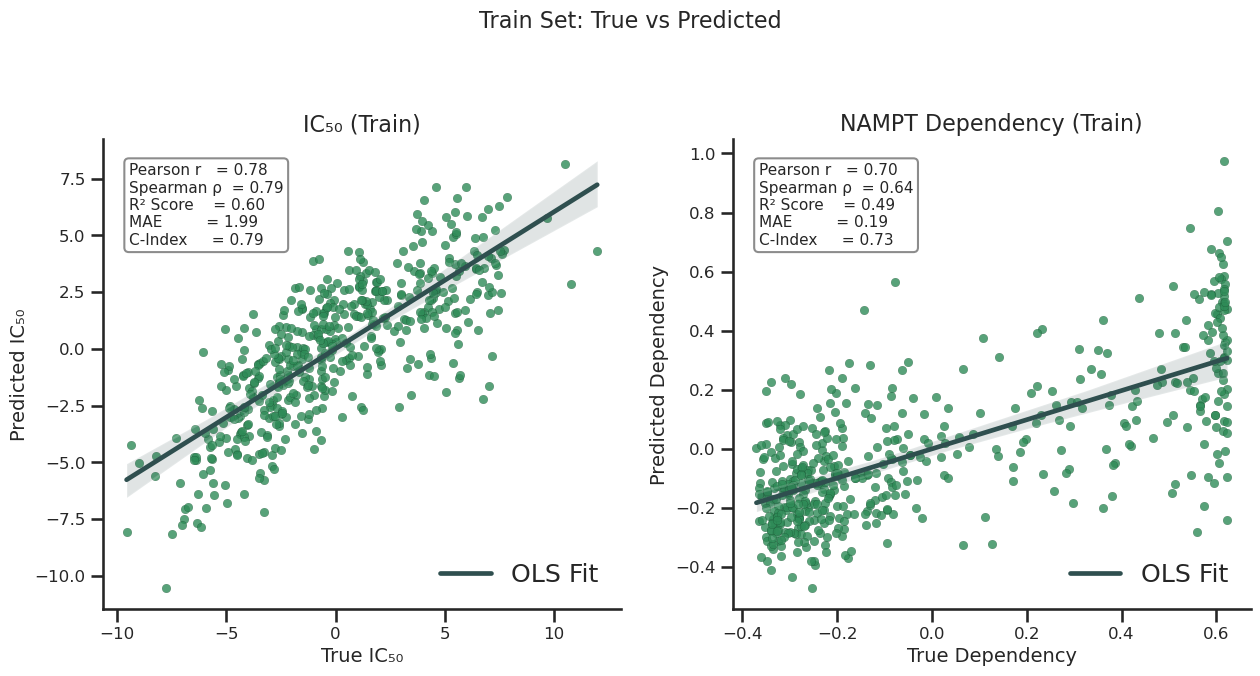

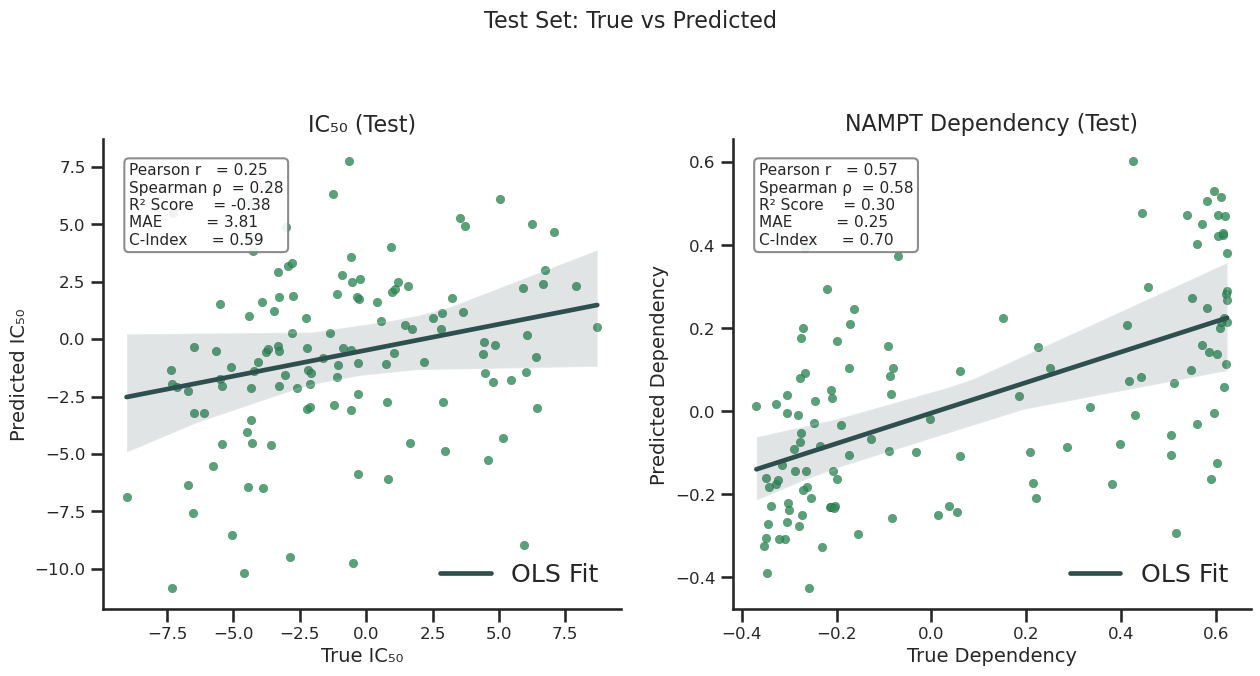

In [223]:
# === Create helper function to handle both plots in a single figure
def plot_two_subplots(x1, y1, x2, y2, title1, title2, xlabel1, ylabel1, xlabel2, ylabel2, main_title):
    fig, axes = plt.subplots(1, 2, figsize=(13, 7))
    
    # Subplot 1
    annotate_and_regress(
        ax=axes[0],
        x=x1,
        y=y1,
        title=title1,
        xlabel=xlabel1,
        ylabel=ylabel1
    )
    
    # Subplot 2
    annotate_and_regress(
        ax=axes[1],
        x=x2,
        y=y2,
        title=title2,
        xlabel=xlabel2,
        ylabel=ylabel2
    )

    fig.suptitle(main_title, fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


# === 🚂 Train Set: True vs Pred IC₅₀ and Dependency
plot_two_subplots(
    x1=I_train,
    y1=pred_I_train,
    x2=D_train,
    y2=pred_D_train,
    title1="IC₅₀ (Train)",
    title2="NAMPT Dependency (Train)",
    xlabel1="True IC₅₀",
    ylabel1="Predicted IC₅₀",
    xlabel2="True Dependency",
    ylabel2="Predicted Dependency",
    main_title="Train Set: True vs Predicted"
)

# === 🧪 Test Set: True vs Pred IC₅₀ and Dependency
plot_two_subplots(
    x1=I_test,
    y1=pred_I_test,
    x2=D_test,
    y2=pred_D_test,
    title1="IC₅₀ (Test)",
    title2="NAMPT Dependency (Test)",
    xlabel1="True IC₅₀",
    ylabel1="Predicted IC₅₀",
    xlabel2="True Dependency",
    ylabel2="Predicted Dependency",
    main_title="Test Set: True vs Predicted"
)


In [226]:
# ---!!!--- IMPORTANT: SIMULATION OF PREDICTED VALUES ---!!!---
pred_dep_train = Z_train @ h_D
pred_ic50_train = Z_train @ h_I
pred_dep_test = Z_test @ h_D
pred_ic50_test = Z_test @ h_I
# --- END OF SIMULATION BLOCK ---

# --- Create separate DataFrames for train and test ---
# Training DataFrame
Z_train_df = pd.DataFrame(Z_train, index=cell_line_names_train, columns=[i + 1 for i in range(Z_train.shape[1])])
Z_train_df["actual_dep_NAMPT"] = raw_dep_train
Z_train_df["actual_IC50"] = raw_ic50_train
Z_train_df["pred_dep_NAMPT"] = pred_dep_train
Z_train_df["pred_IC50"] = pred_ic50_train
Z_train_df["Set"] = "Train"

# Testing DataFrame
Z_test_df = pd.DataFrame(Z_test, index=cell_line_names_test, columns=[i + 1 for i in range(Z_test.shape[1])])
Z_test_df["actual_dep_NAMPT"] = raw_dep_test
Z_test_df["actual_IC50"] = raw_ic50_test
Z_test_df["pred_dep_NAMPT"] = pred_dep_test
Z_test_df["pred_IC50"] = pred_ic50_test
Z_test_df["Set"] = "Test"

# --- Combine into a single DataFrame ---
Z_combined_df = pd.concat([Z_train_df, Z_test_df])
Z_combined_df["Benefit_Score"] = Z_combined_df["pred_dep_NAMPT"] - Z_combined_df["pred_IC50"]
Z_combined_df.index.name = "Cell_line"

# The final dataframe for plotting (only latent factors)
Z_plot_df = Z_combined_df.iloc[:, :Z_train.shape[1]]

print("Z_combined_df DataFrame successfully created:")
Z_combined_df.head()
print(f"Total cell lines to plot: {len(Z_combined_df)}")


Z_combined_df DataFrame successfully created:
Total cell lines to plot: 622


Performing hierarchical clustering on the combined dataset...
..cutHeight not given, setting it to 1308.0804352353432  ===>  99% of the (truncated) height range in dendro.
..done.
Dynamic Tree Cut found 24 clusters.
Generating the final heatmap...


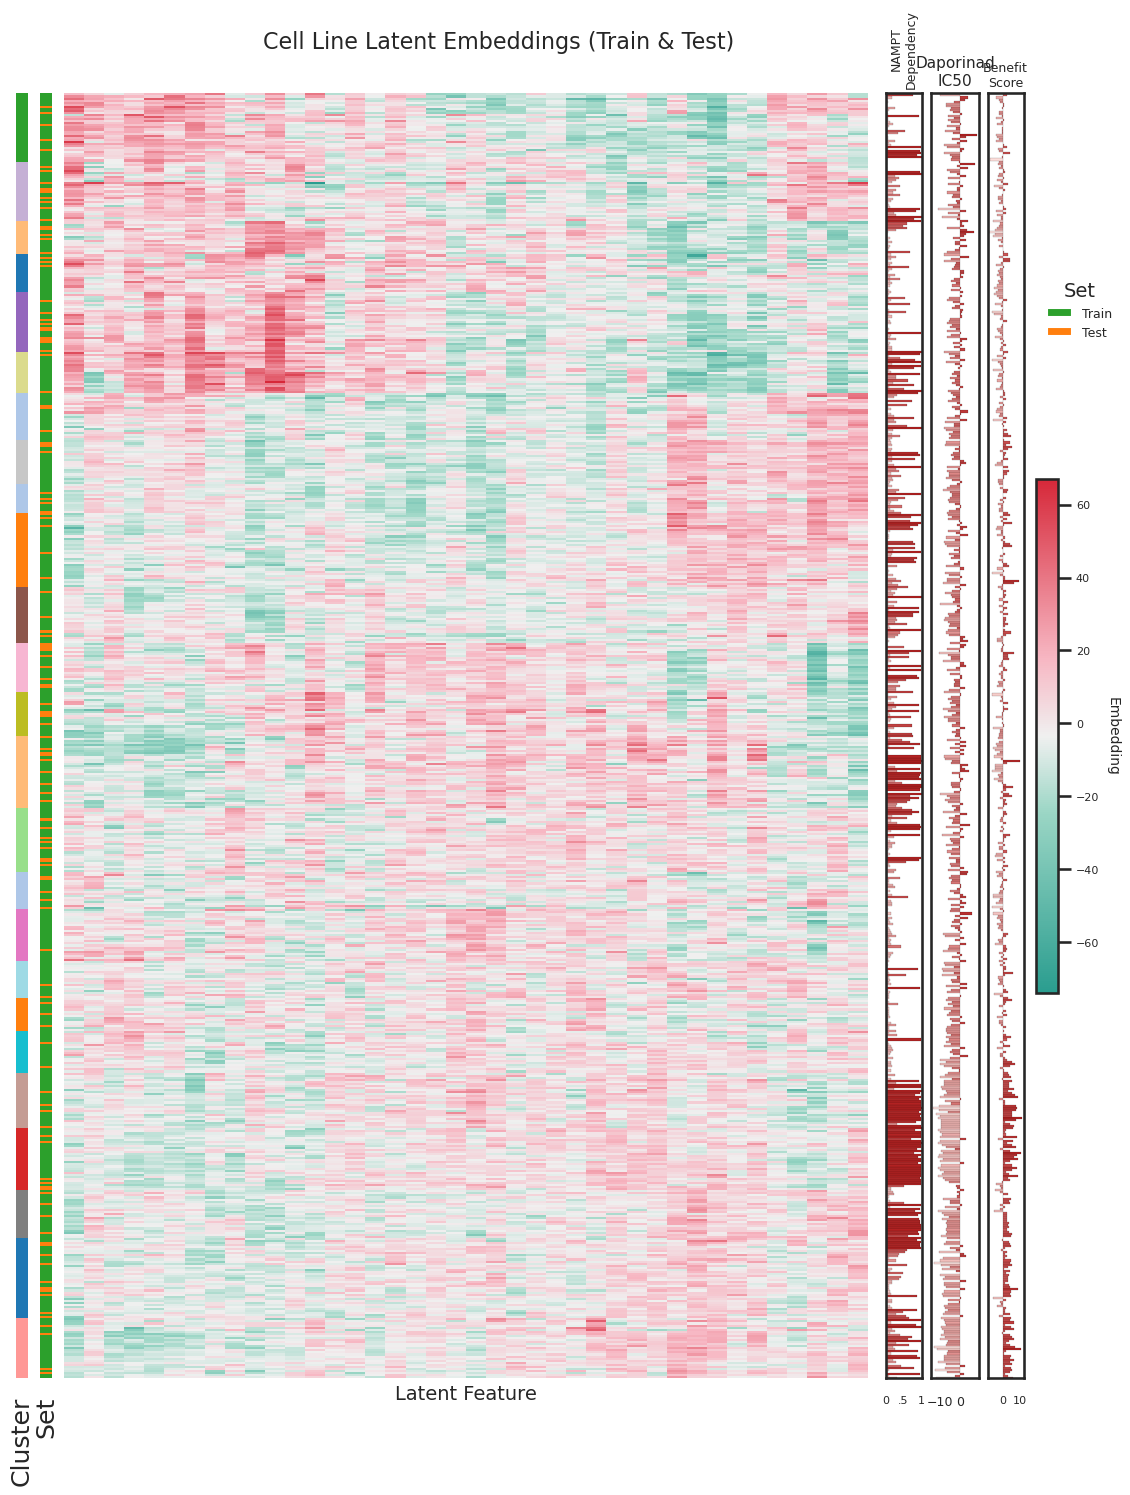

In [231]:
# === 3. Hierarchical Clustering and Annotation Color Mapping (on Combined Data) ===
print("Performing hierarchical clustering on the combined dataset...")

# --- Step 3a: Compute linkage matrices for the combined data ---
row_dist = pdist(Z_plot_df.values, metric='euclidean')
row_link = linkage(row_dist, method='ward')
col_link = linkage(pdist(Z_plot_df.T.values), method='ward')

# --- Step 3b: Run Dynamic Tree Cut to find clusters ---
cluster_result = cutreeHybrid(row_link, row_dist,deepSplit=4, minClusterSize=14) # Set a min size
cluster_labels = pd.Series(cluster_result["labels"], index=Z_plot_df.index, name="Cluster")
num_clusters = len(np.unique(cluster_labels[cluster_labels != 0]))
print(f"Dynamic Tree Cut found {num_clusters} clusters.")

# --- Step 3c: Create annotation colors ---
# This will be a DataFrame, as clustermap can plot multiple annotation bars
row_colors_df = pd.DataFrame(index=Z_plot_df.index)

# Annotation 1: Dynamic Tree Cut Clusters
unique_clusters = sorted(np.unique(cluster_labels))
palette = sns.color_palette("tab20", len(unique_clusters))
cluster_lut = dict(zip(unique_clusters, palette))
cluster_lut[0] = 'lightgrey'  # Unclustered points
row_colors_df["Cluster"] = cluster_labels.map(cluster_lut)

# Annotation 2: Train vs. Test Set
set_lut = {"Train": "#2ca02c", "Test": "#ff7f0e"} # Green and Orange
row_colors_df["Set"] = Z_combined_df["Set"].map(set_lut)

row_colors_df[" "] = "#ffffff"  # White bar to add space between cluster and set
# Reorder to force the stacking order: Cluster (top), Spacer, then Set
row_colors_df = row_colors_df[["Cluster", " ", "Set"]]


# === 4. Define Colormaps ===
deep_green = '#2a9d8f'; soft_green = '#9bd6c5'; neutral = '#f0f0f0'; soft_pink = '#f7b7c3'; deep_pink = '#d62839'
green_pink_cmap = LinearSegmentedColormap.from_list('green_pink_cmap', [(0.0, deep_green), (0.35, soft_green), (0.5, neutral), (0.65, soft_pink), (1.0, deep_pink)], N=256)
muted_reds = LinearSegmentedColormap.from_list("muted_reds", ["mistyrose", "indianred", "firebrick"])
benefit_cmap = sns.diverging_palette(240, 10, as_cmap=True) # Blue to Red for benefit score

# === 5. Generate the Final Clustered Heatmap ===
print("Generating the final heatmap...")
cg = sns.clustermap(
    Z_plot_df,
    row_linkage=row_link,
    col_linkage=col_link,
    row_colors=row_colors_df,  # Pass the DataFrame with both annotations
    cmap=green_pink_cmap,
    figsize=(12, 15),
    cbar_pos=None, # We will create all colorbars manually
    dendrogram_ratio=(0.04, 0.03),
    linewidths=0
)

# Rasterize the heatmap blocks (all quadmesh artists in heatmap)
for artist in cg.ax_heatmap.collections:
    artist.set_rasterized(True)

# === 6. Fine-tune Layout and Add Side Plots ===
fig = cg.fig
heatmap_ax = cg.ax_heatmap
# Remove latent dimension numbers from the x-axis
heatmap_ax.set_xticklabels([])
heatmap_ax.set_xticks([])  # Optional: remove the ticks themselves
heatmap_pos = heatmap_ax.get_position()


# --- Adjust annotation and dendrogram positions ---
cg.ax_row_colors.set_position([heatmap_pos.x0 - 0.04, heatmap_pos.y0, 0.03, heatmap_pos.height])
if cg.ax_col_colors is not None:
    cg.ax_col_colors.set_visible(False)



#cg.ax_col_colors.set_visible(False) # Hide column colors if they exist
dendro_ax = cg.ax_row_dendrogram
dendro_ax.set_position([0.02, heatmap_pos.y0, 0.05, heatmap_pos.height])

cg.ax_row_dendrogram.set_visible(False)
cg.ax_col_dendrogram.set_visible(False)


# --- Configure heatmap axes and labels ---
row_order = cg.dendrogram_row.reordered_ind
ordered_labels = Z_plot_df.index[row_order]
tick_labels = [label if i % 10 == 0 else "" for i, label in enumerate(ordered_labels)] # Adjust frequency
heatmap_ax.set_yticks(np.arange(len(ordered_labels)) + 0.5)
#heatmap_ax.set_yticklabels(tick_labels, fontsize=6.5, rotation=0)
heatmap_ax.set_yticklabels([])
heatmap_ax.set_yticks([])

heatmap_ax.tick_params(axis='y', labelright=False, labelleft=True, length=0, pad=1)

# --- Add Bar Plot 1: EGFR Dependency ---
egfr_ax = fig.add_axes([heatmap_pos.x1 + 0.015, heatmap_pos.y0, 0.03, heatmap_pos.height])
egfr_vals = Z_combined_df.loc[ordered_labels, "actual_dep_NAMPT"]
egfr_colors = muted_reds(Normalize(vmin=0, vmax=1)(egfr_vals))
egfr_ax.barh(np.arange(len(egfr_vals)), egfr_vals, height=1.0, color=egfr_colors, edgecolor='black', linewidth=0.1)
egfr_ax.set_xlim(0, 1); egfr_ax.set_ylim(0, len(ordered_labels))
egfr_ax.set_xticks([0, 0.5, 1]); egfr_ax.set_xticklabels(["0", ".5", "1"], fontsize=8)
egfr_ax.set_yticks([]); egfr_ax.set_title("NAMPT\nDependency", fontsize=9, rotation=90)
for bar in egfr_ax.patches:
    bar.set_rasterized(True)

# --- Add Bar Plot 2: IC50 ---
ic50_ax = cg.fig.add_axes([heatmap_pos.x1 + 0.053, heatmap_pos.y0, 0.04, heatmap_pos.height])
ic50_vals = Z_combined_df.loc[ordered_labels, "actual_IC50"]
ic50_colors = muted_reds(Normalize(vmin=ic50_vals.min(), vmax=ic50_vals.max())(ic50_vals))
bars2 = ic50_ax.barh(np.arange(len(ic50_vals)), ic50_vals, height=1.0, color=ic50_colors, edgecolor='black', linewidth=0.1)
for bar in bars2: bar.set_rasterized(True)
ic50_ax.set_ylim(0, len(ordered_labels)); ic50_ax.set_yticks([])
ic50_ax.tick_params(axis='x', labelsize=9); ic50_ax.set_title(f"Daporinad\nIC50", fontsize=11, loc='center')



# --- Add Bar Plot 3: Benefit Score ---
benefit_ax = fig.add_axes([heatmap_pos.x1 + 0.1, heatmap_pos.y0, 0.03, heatmap_pos.height])
benefit_vals = Z_combined_df.loc[ordered_labels, "Benefit_Score"]
benefit_colors = muted_reds(Normalize(vmin=benefit_vals.min(), vmax=benefit_vals.max())(benefit_vals))
#benefit_norm = Normalize(vmin=benefit_vals.min(), vmax=benefit_vals.max())
#benefit_ax.barh(np.arange(len(benefit_vals)), benefit_vals, height=1.0, color=benefit_cmap(benefit_norm(benefit_vals)))
benefit_ax.barh(np.arange(len(benefit_vals)), benefit_vals, height=1.0, color=benefit_colors, edgecolor='black', linewidth=0.1)
benefit_ax.set_ylim(0, len(ordered_labels)); benefit_ax.set_yticks([])
benefit_ax.tick_params(axis='x', labelsize=8)
benefit_ax.set_title("Benefit\nScore", fontsize=9, loc='center', pad=5)
for bar in benefit_ax.patches:
    bar.set_rasterized(True)


# --- Add Manual Colorbar for Heatmap ---
#cbar_ax = fig.add_axes([heatmap_pos.x1 + 0.15, heatmap_pos.y0, 0.015, heatmap_pos.height * 0.4])
cbar_ax = fig.add_axes([
    heatmap_pos.x1 + 0.14,                                 # right of bar plots
    heatmap_pos.y0 + heatmap_pos.height * 0.3,             # vertically centered
    0.019,
    heatmap_pos.height * 0.4
])
vmin, vmax = Z_plot_df.values.min(), Z_plot_df.values.max()
norm = Normalize(vmin=vmin, vmax=vmax)
sm = plt.cm.ScalarMappable(cmap=green_pink_cmap, norm=norm)
cbar = fig.colorbar(sm, cax=cbar_ax)
cbar.ax.tick_params(labelsize=8)
cbar.set_label('Embedding', fontsize=10, rotation=270, labelpad=15)


# --- Add Manual Legend for Cluster and Set Annotations ---
from matplotlib.patches import Patch
legend_ax = fig.add_axes([heatmap_pos.x1 + 0.14, heatmap_pos.y0 + heatmap_pos.height*0.80, 0.015, heatmap_pos.height*0.25])
handles = [Patch(facecolor=color, label=label) for label, color in set_lut.items()]
legend_ax.legend(handles=handles, title='Set', frameon=False, loc='lower left', fontsize=9, title_fontsize = 14)
legend_ax.axis('off')
# --- Add Manual Legend for Cluster and Set Annotations --


# --- Final Titles and Layout Adjustments ---
heatmap_ax.set_xlabel("Latent Feature", fontsize=14); heatmap_ax.set_ylabel("")
num_cell_lines = len(Z_combined_df)
fig.suptitle(f"Cell Line Latent Embeddings (Train & Test)", y=0.99, fontsize=16)


plt.show()